###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2024 Semester 1

## Assignment 1: Wine quality classification with K-NN


**Student ID(s):**     `1319881`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

**Adding proper comments to your code is MANDATORY. **

## 1. K-NN classifier

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_data = pd.read_csv('winequality-train.csv')
test_data = pd.read_csv('winequality-test.csv')

#separate features and labels for training and test data
X_train = train_data.iloc[:, :-1]  #features
y_train = train_data.iloc[:, -1]  #label

X_test = test_data.iloc[:, :-1]  #features
y_test = test_data.iloc[:, -1]  #label

def euclidean_distance(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    distance = np.sqrt(np.sum((x1 - x2) ** 2))  #doing matrix operations using numpy
    return distance

def get_neighbors(X_train, y_train, test_instance, k):
    """
    Get the k nearest neighbors of a test instance from the training data
    """
    distances = []  #store a tuple pair (training_instance, label) and the euclidean distance
    for i, train_instance in X_train.iterrows():
        length = euclidean_distance(test_instance, train_instance)
        label = y_train.iloc[i]
        distances.append(((train_instance, label), length))
    distances.sort(key=lambda x: x[1])  #sort the length based on euclidean distance in ascending order (smallest to largest)
    
    neighbors = []  
    current_length = None  #keep track of the euclidean distance of the neibghbor added into the list
    for neighbor in distances:
        if current_length is None:  #add the first neighbor into the list
            neighbors.append(neighbor)
            current_length = neighbor[1]  
        else:
            if len(neighbors) < k-1:
                neighbors.append(neighbor)
                current_length = neighbor[1]  #update the current length
            elif len(neighbors) == k - 1:
                same_length_neighbors = [neighbor for neighbor in distances if neighbor[1] == current_length]
                if len(same_length_neighbors) > 0:
                    neighbors.append(random.choice(same_length_neighbors))  #tie break by choosing randomly among the same euclidean distances
                else: 
                    neighbors.append(neighbor)
            else:  
                break  #len(neighbors) == k
    return neighbors


def get_label(neighbors):
    """
    Determine the label of a test instance based on its k nearest neighbors
    """
    label_counts = {}  #key is the label, value is the number of occurences of the corresponding key
    
    for neighbor in neighbors:
        label = neighbor[0][1]  #get the inner tuple (training_instance, label) and access the label
        label_counts[label] = label_counts.get(label, 0) + 1
    sorted_counts = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)  #sort the dictionary in descending order (largest to smallest) based on the counts

    if len(sorted_counts) == 1:  
        return sorted_counts[0][0]  
    elif len(sorted_counts) > 1:
        max_count = sorted_counts[0][1]
        max_labels = [label for label, count in sorted_counts if count == max_count]  #store all the labels that have the maximum count
        if len(max_labels) == 1:
            #majority vote with no tie
            return max_labels[0]
        else:
            #majority vote with tie, break tie with 1-NN
            sorted_neighbors = sorted(neighbors, key=lambda x: x[1])  #sort neighbors based on the euclidean distance in ascending order
            for neighbor in sorted_neighbors:
                label = neighbor[0][1]
                if label in max_labels:
                    return label  #return the label of the first neighbor whose label is among the labels with the maximum count 


def knn_classifier(X_train, y_train, X_test, k):
    """
    Classify the test instances using the KNN algorithm
    """
    predictions = []
    for i, test_instance in X_test.iterrows():
        neighbors = get_neighbors(X_train, y_train, test_instance, k)
        label = get_label(neighbors)
        predictions.append(label)
    return predictions


In [2]:
#test the K-NN algorithm with k
k=1
knn1_predictions = knn_classifier(X_train, y_train, X_test, k)

# Store the predictions in an array
predictions_array = np.array(knn1_predictions)

print("Predictions:")
print(predictions_array)

Predictions:
[0 0 1 ... 1 0 1]


## 2. 1-NN classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [3]:
knn1_acc = accuracy_score(y_test, knn1_predictions)  #use knn1_predictions from Q1 to calculate the accuracy
print(f"Accuracy of 1-NN classifier: {knn1_acc * 100:.2f}%")

Accuracy of 1-NN classifier: 76.44%


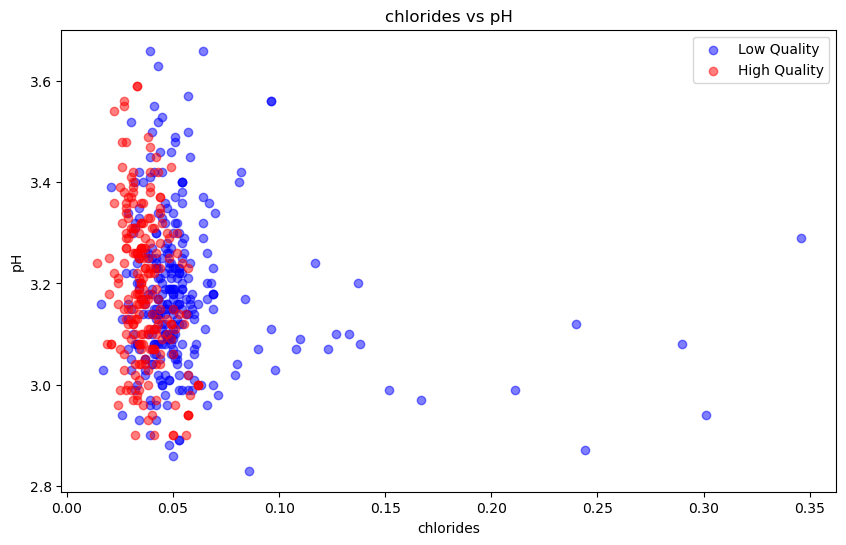

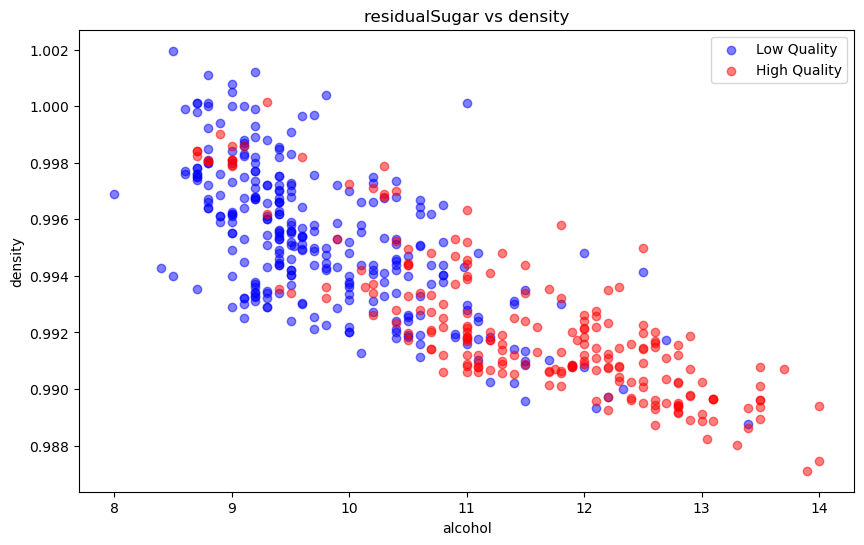

In [4]:
#plot a scatterplot of two random attributes from the training dataset
attribute1 = 'chlorides'
attribute2 = 'pH'

#select a radndom subset of the training data
X_train_subset = X_train.sample(n = 500, random_state = 42)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_subset.loc[y_train == 0, attribute1], X_train_subset.loc[y_train == 0, attribute2], color='blue', label='Low Quality', alpha = 0.5)
plt.scatter(X_train_subset.loc[y_train == 1, attribute1], X_train_subset.loc[y_train == 1, attribute2], color='red', label='High Quality', alpha = 0.5)
plt.xlabel(attribute1)
plt.ylabel(attribute2)
plt.title("chlorides vs pH")
plt.legend()
plt.show()

#plot another scatterplot of two random attributes from the training dataset
attribute1 = 'alcohol'
attribute2 = 'density'

plt.figure(figsize=(10, 6))
plt.scatter(X_train_subset.loc[y_train == 0, attribute1], X_train_subset.loc[y_train == 0, attribute2], color='blue', label='Low Quality', alpha = 0.5)
plt.scatter(X_train_subset.loc[y_train == 1, attribute1], X_train_subset.loc[y_train == 1, attribute2], color='red', label='High Quality', alpha = 0.5)
plt.xlabel(attribute1)
plt.ylabel(attribute2)
plt.title("residualSugar vs density")
plt.legend()
plt.show()

## 3. Normalization

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [5]:
def min_max_scale(X, X_train):
    X_scale = (X - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))
    return X_scale

def standardize(X, X_train):
    X_std = (X - X_train.mean(axis=0)) / X_train.std(axis=0)
    return X_std

#store the model accuracies in a dictionary (used in Q4)
models = {}

#min-max scale accuracy
X_train_minmax = min_max_scale(X_train, X_train)
X_test_minmax = min_max_scale(X_test, X_train)
minmax_predictions = knn_classifier(X_train_minmax, y_train, X_test_minmax, k=1)
knn1_minmax_acc = accuracy_score(y_test, minmax_predictions)
print(f"Accuracy of 1-NN min-max scale: {knn1_minmax_acc * 100:.2f}%")

#standardization accuracy
X_train_std = standardize(X_train, X_train)
X_test_std = standardize(X_test, X_train)
std_predictions = knn_classifier(X_train_std, y_train, X_test_std, k=1)
knn1_std_acc = accuracy_score(y_test, std_predictions)
print(f"Accuracy of 1-NN standardization: {knn1_std_acc * 100:.2f}%")

#unnormalized data accuracy
print(f"Accuracy of 1-NN unnormalized classifier: {knn1_acc * 100:.2f}%")
print()

#store accuracy for different models in the dictionary (used in Q4)
models['1-NN Min-Max Scale'] = knn1_minmax_acc  
models['1-NN Standardization'] = knn1_std_acc
models['1-NN Unnormalized'] = knn1_acc

Accuracy of 1-NN min-max scale: 85.04%
Accuracy of 1-NN standardization: 86.74%
Accuracy of 1-NN unnormalized classifier: 76.44%



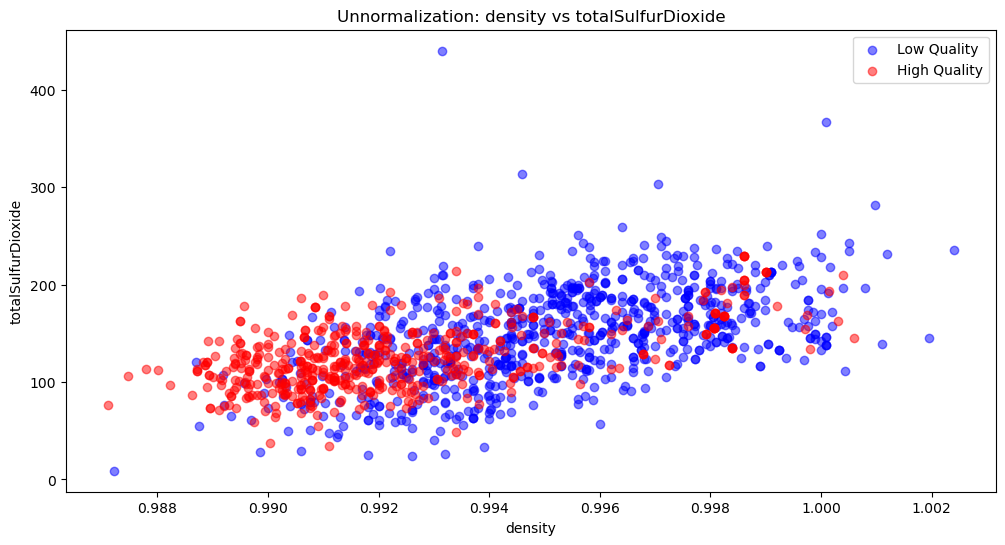

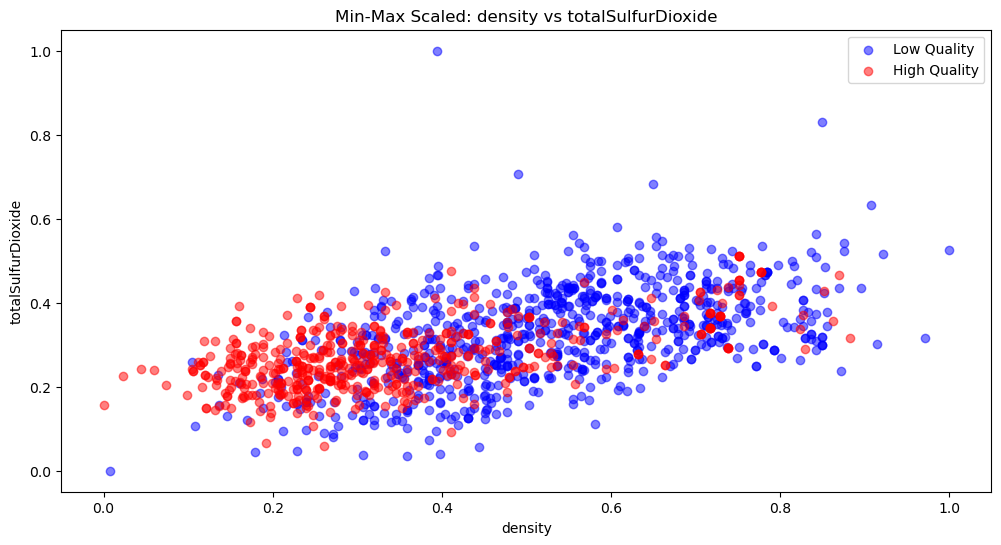

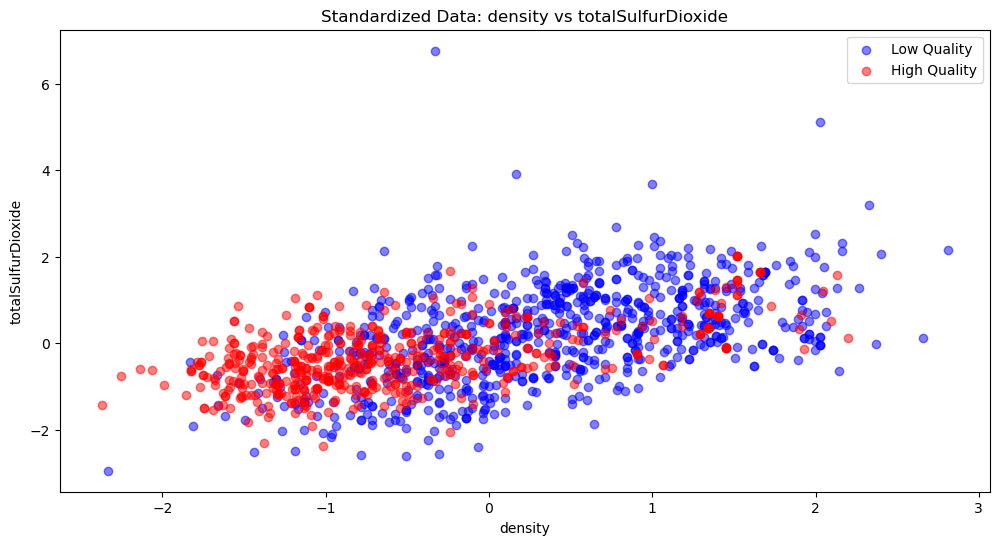

In [6]:
#plot scatterplots of two random attributes from the training dataset
feature1 = 'density'
feature2 = 'totalSulfurDioxide'

# Scatterplot of unnormalized data
plt.figure(figsize=(12, 6))
plt.scatter(X_train[y_train == 0][feature1], X_train[y_train == 0][feature2], color='blue', label='Low Quality', alpha = 0.5)
plt.scatter(X_train[y_train == 1][feature1], X_train[y_train == 1][feature2], color='red', label='High Quality', alpha = 0.5)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Unnormalization: density vs totalSulfurDioxide")
plt.legend()
plt.show()

# Scatterplot of min-max scaled data
plt.figure(figsize=(12, 6))
plt.scatter(X_train_minmax[y_train == 0][feature1], X_train_minmax[y_train == 0][feature2], color='blue', label='Low Quality', alpha = 0.5)
plt.scatter(X_train_minmax[y_train == 1][feature1], X_train_minmax[y_train == 1][feature2], color='red', label='High Quality', alpha = 0.5)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Min-Max Scaled: density vs totalSulfurDioxide")
plt.legend()
plt.show()

# Scatterplot of standardized data
plt.figure(figsize=(12, 6))
plt.scatter(X_train_std[y_train == 0][feature1], X_train_std[y_train == 0][feature2], color='blue', label='Low Quality', alpha = 0.5)
plt.scatter(X_train_std[y_train == 1][feature1], X_train_std[y_train == 1][feature2], color='red', label='High Quality', alpha = 0.5)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Standardized Data: density vs totalSulfurDioxide")
plt.legend()
plt.show()

## 4. Model extensions

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### 4.1
Compare the performance of your best 1-NN model from Question 3 to a Gaussian naive Bayes model on this dataset (you may use library functions to implement the Gaussian naive Bayes model). In your write-up, state the accuracy of the naive Bayes model and identify instances where the two models disagree. Why do the two models classify these instances differently?

In [7]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
gnv_acc = gnb.score(X_test, y_test)
best_model = max(models.items(), key=lambda k: k[1])
print(f"Accuracy of 1-NN classifier on Gaussian Naive Bayes model: {gnv_acc * 100:.2f}%")
print(f"The best 1-NN classifier from Question 3 is {best_model[0]} with an accuracy of {best_model[1] * 100:.2f}%")
print()

#create a dataframe to store the predictions
df = pd.DataFrame({
    'Instance': range(1, len(X_test) + 1),
    'GNB Prediction': gnb_predictions,
    'Standardization Prediction': std_predictions,
    'True Label': y_test
})

disagreements = df[df['GNB Prediction'] != df['Standardization Prediction']]
dis_percent = len(disagreements) / len(df)

print(f"There are {len(disagreements)} instances where the GNB model and the standardization model disagree, with a percentage of {dis_percent * 100:.2f}%")
print(disagreements.to_string(index=False))
print()
instances = disagreements.iloc[:, 0].to_numpy()
print("Instances where the GNB model and the standardization model disagree:")
print(instances)

Accuracy of 1-NN classifier on Gaussian Naive Bayes model: 77.78%
The best 1-NN classifier from Question 3 is 1-NN Standardization with an accuracy of 86.74%

There are 265 instances where the GNB model and the standardization model disagree, with a percentage of 19.63%
 Instance  GNB Prediction  Standardization Prediction  True Label
        1               1                           0           0
       10               1                           0           1
       19               0                           1           0
       20               0                           1           0
       24               0                           1           0
       27               0                           1           0
       28               1                           0           0
       30               0                           1           1
       36               1                           0           0
       55               0                           1           0
   

<Figure size 1200x800 with 0 Axes>

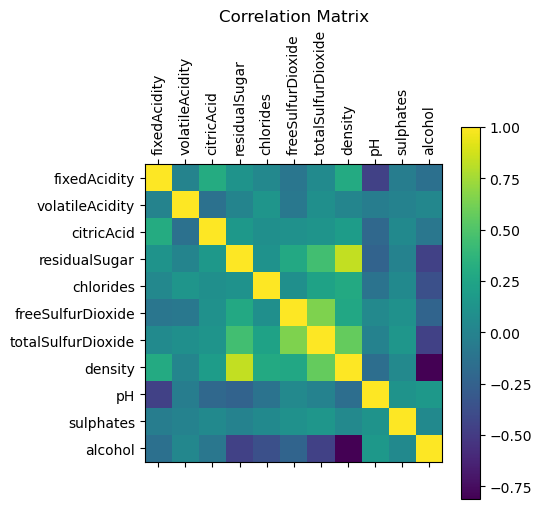

In [11]:
#find which features are not independent by creating a correlation matrix of the training data
correlation_matrix = X_train.corr()
plt.figure(figsize=(12, 8))
plt.matshow(correlation_matrix, cmap='viridis')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()

### 4.2
Implement two additional distance measures for your K-NN model: cosine similarity and Mahalanobis distance (you may use library functions for these distance measures). Do 1-NN classification using each of these new distance measures and the three normalization options from Question 3. Discuss how the new distance metrics compare to Euclidean distance and how each metric is affected by normalization.

### 4.3
Implement either of the two K-NN weighting strategies discussed in lecture (inverse linear distance or inverse distance). Compare the performance of the weighted and majority vote models for a few different values of K. In your write-up, discuss how weighting strategy and the value of K affect the model's decisions.

### 4.4
Measure the empirical distribution of class labels in the training dataset (what percentage of the training data comes from each class). Then evaluate the distribution of labels predicted by your K-NN model for the test data, for a range of values for K. Does the class distribution of the predicted labels match the class distribution of the training data? Explain why or why not.